In [1]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

In [2]:
%cd
%cd nbs/fastai/
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu
/home/ubuntu/nbs/fastai


# Setting Up Data

In [3]:
%cd ~/nbs/
DataPath = 'data/dogscats/'
#image size, pixel by pixel = sz by sz
sz = 224

/home/ubuntu/nbs


In [4]:
%ls {DataPath}

models/  sample/  test/  tmp/  train/  valid/


In [5]:
files = !ls {DataPath}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

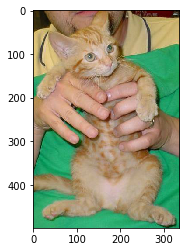

In [23]:
img = plt.imread(f'{DataPath}valid/cats/{files[1]}')
plt.imshow(img)

In [22]:
img.shape

(198, 179, 3)

In [25]:
img[:4, :4]

array([[[60, 58, 10],
        [60, 57, 14],
        [61, 56, 18],
        [63, 54, 23]],

       [[56, 54,  6],
        [56, 53, 10],
        [57, 52, 14],
        [60, 51, 20]],

       [[52, 49,  4],
        [52, 49,  6],
        [53, 48, 10],
        [56, 47, 16]],

       [[50, 47,  2],
        [50, 47,  4],
        [51, 45,  9],
        [53, 44, 13]]], dtype=uint8)

# ResNet Model

In [6]:
arch = resnet34
data = ImageClassifierData.from_paths(DataPath, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.048201   0.026179   0.989746  



[0.026179103, 0.98974609375]

In [7]:
learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.036324   0.026353   0.990723  
    1      0.034571   0.026726   0.990234  
    2      0.034644   0.027217   0.989746  



[0.027217131, 0.98974609375]

# Analyzing Results

In [36]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
data.classes

['cats', 'dogs']

In [41]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [50]:
log_preds[1000:1005]

array([[-10.82933,  -0.00002],
       [-12.47888,  -0.     ],
       [ -8.16454,  -0.00028],
       [-18.09239,  -0.     ],
       [-14.437  ,  -0.     ]], dtype=float32)

In [52]:
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds[:,1])

In [53]:
preds[:5]

array([0, 0, 0, 0, 0])

In [54]:
probs[:5]

array([0.     , 0.00007, 0.00218, 0.     , 0.     ], dtype=float32)

In [4]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace = False)
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [5]:
def plots(imgs, figsize = (12,6), rows = 1, titles = None):
    f = plt.figure(figsize = figsize)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles !=  None: sp.set_title(titles[i], fontsize = 16)
        plt.imshow(imgs[i])
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(DataPath + ds.fnames[idx]))
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows = 1, titles = title_probs, figsize = (16,8))

Correctly Classified


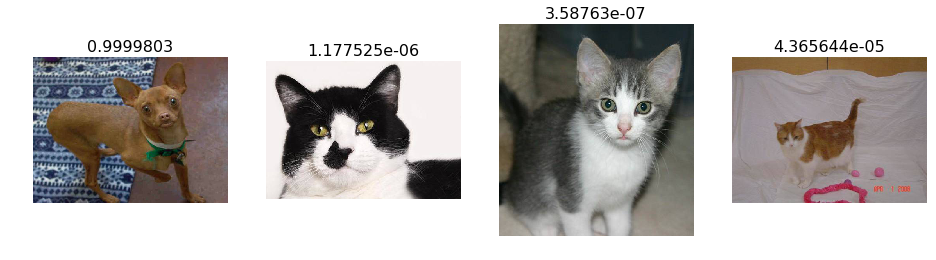

In [66]:
plot_val_with_title(rand_by_correct(True), "Correctly Classified")

Incorrectly Classified


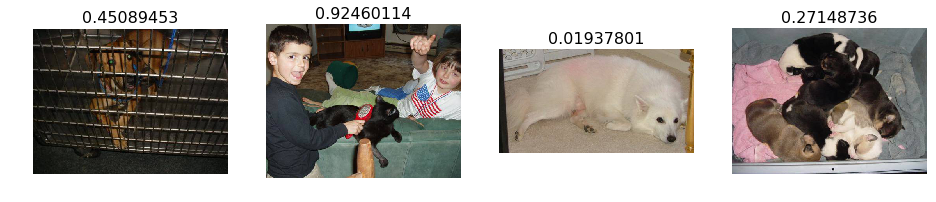

In [67]:
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

In [6]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]
def most_by_correct(y, is_correct):
    mult = -1 if (y==1) == is_correct else 1
    return most_by_mask(((preds == data.val_y) == is_correct) & (data.val_y == y), mult)

Most Correct Cats


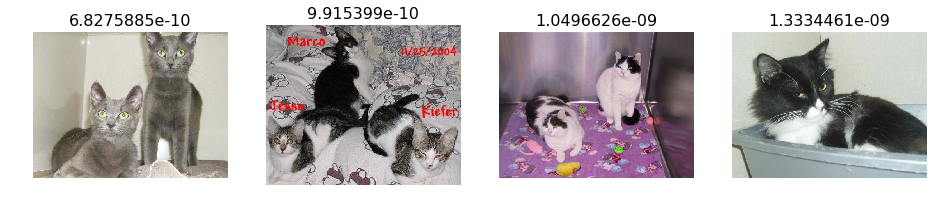

In [71]:
plot_val_with_title(most_by_correct(0, True), "Most Correct Cats")

Most Correct Dogs


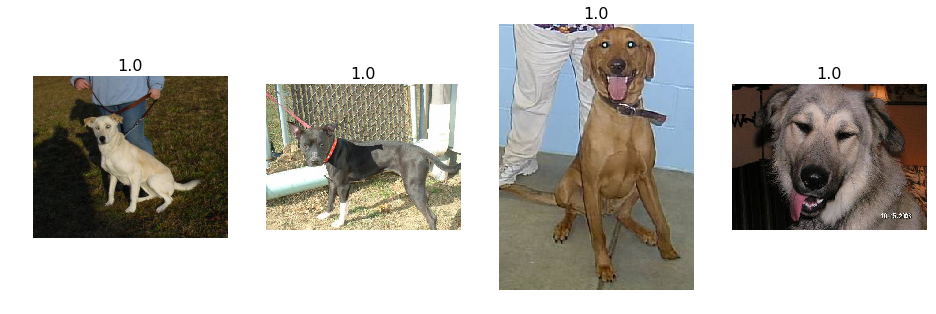

In [72]:
plot_val_with_title(most_by_correct(1, True), "Most Correct Dogs")

Most Incorrect Cats


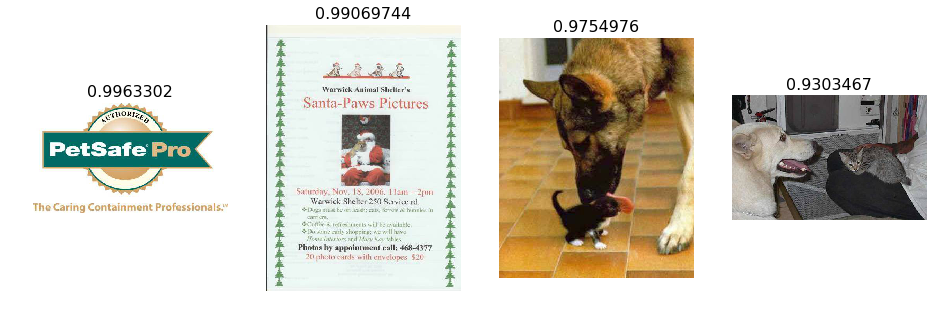

In [73]:
plot_val_with_title(most_by_correct(0, False), "Most Incorrect Cats")

Most Incorrect Dogs


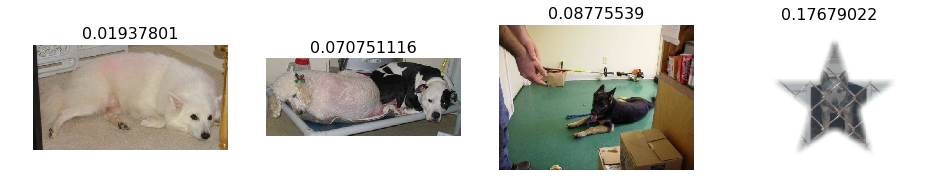

In [75]:
plot_val_with_title(most_by_correct(1, False), "Most Incorrect Dogs")

Most Uncertain Predictions


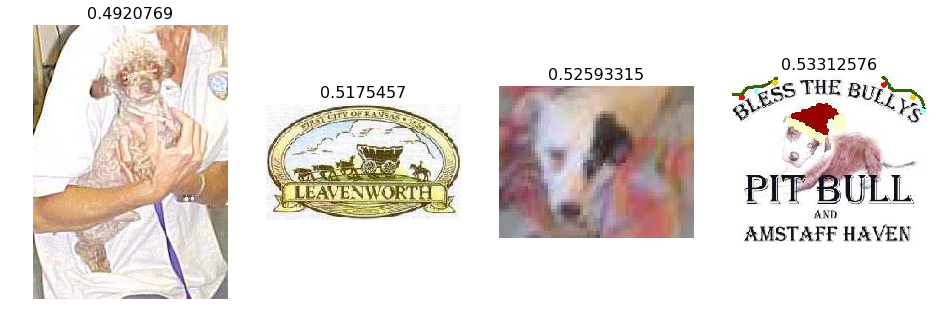

In [92]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most Uncertain Predictions")

In [97]:
np.abs(probs[998:1002] - .5)

array([0.5    , 0.49991, 0.49998, 0.5    ], dtype=float32)

In [98]:
np.argsort(np.abs(probs[998:1002] - .5))

array([1, 2, 3, 0])

# Analyzing Learning Rates

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [19]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▍ | 305/360 [00:05<00:01, 54.00it/s, loss=0.42]


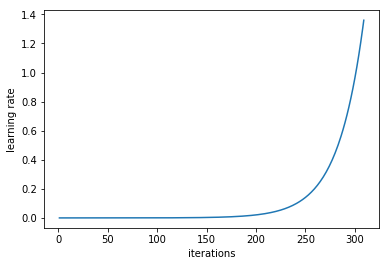

In [20]:
learn.sched.plot_lr()

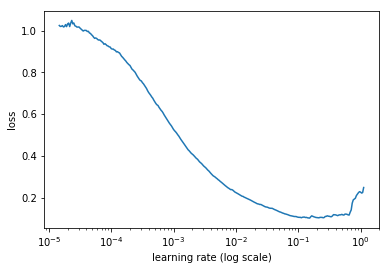

In [22]:
learn.sched.plot()

# Data Augmentation

In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)

In [11]:
def get_augs():
    data = ImageClassifierData.from_paths(DataPath, bs = 2, tfms = tfms, num_workers = 1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [12]:
imgs = np.stack([get_augs() for i in range(6)])

Here are 6 ways one picture was visually augmented.

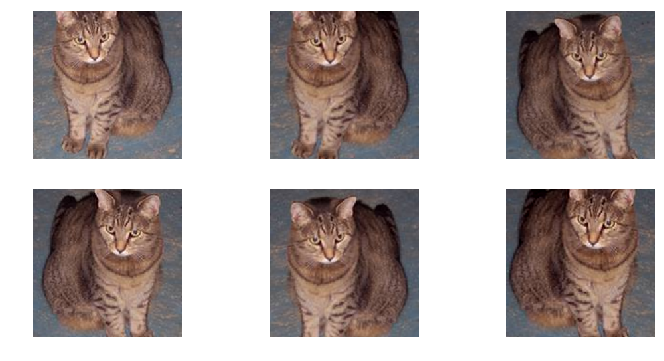

In [13]:
plots(imgs, rows = 2)

In [14]:
dataAug = ImageClassifierData.from_paths(DataPath, tfms = tfms)
learnAug = ConvLearner.pretrained(arch, dataAug, precompute = True)

In [15]:
learnAug.fit(.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.053911   0.026754   0.990723  



[0.026754431, 0.99072265625]

In [16]:
learnAug.precompute = False

In [17]:
learnAug.fit(.01, 3, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.042646   0.025395   0.991211  
    1      0.03945    0.02708    0.98877   
    2      0.030783   0.024112   0.991211  



[0.024111908, 0.9912109375]

Learning Rate Annealing

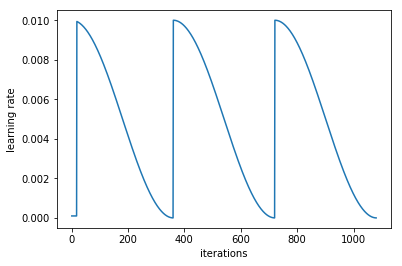

In [18]:
learnAug.sched.plot_lr()

In [20]:
learnAug.save('resnet34_aug_224_last_layer')

In [20]:
learnAug.load('resnet34_aug_224_last_layer')

Fine-Tuning and Differential Learning Rate Annealing

In [21]:
learnAug.unfreeze()

In [23]:
lr = np.array([.0001, .001, .01])

In [31]:
learnAug.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.031219   0.025428   0.989258  
    1      0.028435   0.025738   0.989258  
    2      0.027048   0.025323   0.989746  
    3      0.031758   0.025318   0.989746  
    4      0.038482   0.025295   0.989746  
    5      0.03265    0.025806   0.989746  
    6      0.028013   0.025452   0.990723  



[0.025452156, 0.99072265625]

In [ ]:
learnAug.save('resnet34_aug_224_all_layer')

In [ ]:
learnAug.load('resnet34_aug_224_all_layer')

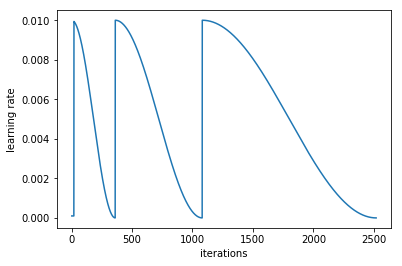

In [32]:
learnAug.sched.plot_lr()

In [80]:
log_preds, y = learnAug.TTA()
#accuracy(log_preds, y)
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y)

0.9905

In [70]:
log_preds.shape

(5, 2000, 2)

# Confusion Matrix

In [81]:
preds = np.argmax(probs, axis = 1)
probs = probs[:,1]

In [83]:
probs.shape

(2000,)

In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[990  10]
 [  9 991]]


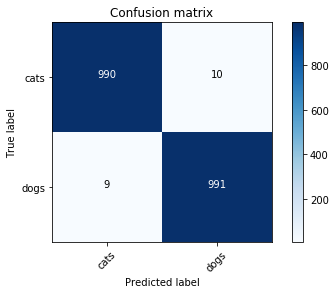

In [86]:
plot_confusion_matrix(cm, dataAug.classes)